In [1]:
from utils.data.create_local_t5data import get_trial_data
from datasets import get_testing_data
from utils_f import get_config
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime
from utils.plot.plot_true_vs_pred_mvmnt import plot_true_vs_pred_mvmnt
import torch
from utils_f import get_config_from_file, set_seeds, set_device
from datasets import get_trial_data, chop, smooth_spikes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import plotly.graph_objects as go
from matplotlib import cm, colors
import matplotlib.pyplot as plt
import shutil
import os
import sys
import wandb
import pandas as pd
import copy

/home/dmifsud/miniconda3/envs/ndtu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
path = '/home/dmifsud/Projects/NDT-U/runs/train/honest-sweep-10/last.pt'
# path = '/home/dmifsud/Projects/NDT-U/runs/train/stellar-sweep-1/last.pt'
# path = '/home/dmifsud/Projects/NDT-U/runs/train/sweet-serenity-164/last.pt'
# path = '/home/dmifsud/Projects/NDT-U/runs/train/polar-violet-159/last.pt'

In [49]:
name = path[:path.rindex('/')].split('/')[-1]
config = get_config_from_file(path[:path.rindex('/')+1]+'config.yaml')
if not os.path.isdir(f"plots/{name}"): os.makedirs(f"plots/{name}")
shutil.copyfile(path[:path.rindex('/')+1]+'config.yaml', f"plots/{name}/config.yaml")

set_seeds(config)
set_device(config, {})
device = torch.device('cuda:0')

model = torch.load(path).to(device)
model.name = name

model.eval()

datasets = get_testing_data(config)
session_csv = pd.read_csv(f'{config.data.dir}/sessions.csv')

In [5]:
session = 't5.2021.05.05'
# session = 't5.2021.05.17'

In [6]:
dataset = copy.deepcopy(datasets[session]) 

session_csv = pd.read_csv(f'{config.data.dir}/sessions.csv')

# remove corr channels
if config.data.rem_xcorr: 
    corr, corr_chans = dataset.get_pair_xcorr('spikes', threshold=0.2, zero_chans=True)

    # to visualize correlated chans, edit the base class to output pairs
    # corr, corr_chans, pairs = dataset.get_pair_xcorr('spikes', threshold=0.2, zero_chans=True)
    # plot_xcorr_hist(pairs, i=f'{session}', hist_binwidth=0.005, title=f'{session}')

# resample to 10ms and smooth
dataset.resample(config.data.bin_size / 1000)
dataset.smooth_spk(60, name='smth')

# get trials to ignore
failed_trials = ~dataset.trial_info['is_successful'] 
center_trials = dataset.trial_info['is_center_target']
ol_block = session_csv.loc[session_csv['session_id'] == session, 'ol_blocks'].item()
cl_blocks =  ~dataset.trial_info['block_num'].isin([ol_block]).values.squeeze()

# get ol spikes
spks = dataset.data[dataset.data['blockNums'].isin([ol_block]).values.squeeze()].spikes.to_numpy()
smth_spks = dataset.data[dataset.data['blockNums'].isin([ol_block]).values.squeeze()].spikes_smth.to_numpy()
spks_idx = dataset.data[dataset.data['blockNums'].isin([ol_block]).values.squeeze()].spikes.index

# get heldin and heldout channels
n_channels = dataset.data.spikes.shape[-1]
n_heldout = int(config.data.heldout_pct * n_channels)
n_heldin = n_channels - n_heldout
np.random.seed(config.setup.seed)
heldout_channels = np.random.choice(n_channels, n_heldout, replace=False)
heldin_channels = torch.ones(n_channels, dtype=bool)
heldin_channels[heldout_channels] = False

In [7]:
# chop spikes and get session names
chopped_spks = chop(np.array(spks[:, heldin_channels]), 30, 29)
hi_chopped_spks = torch.Tensor(chopped_spks).to(device)

names = [session for i in range(hi_chopped_spks.shape[0])]

### Model Inference

In [50]:
with torch.no_grad():
    torch_rates, output = model(hi_chopped_spks, names)

In [51]:

mean = dataset.data[dataset.data['blockNums'].isin([ol_block]).values.squeeze()].spikes.mean(0).to_numpy()
std = dataset.data[dataset.data['blockNums'].isin([ol_block]).values.squeeze()].spikes.std(0).to_numpy()

# mean = dataset.data[dataset.data['blockNums'].isin([ol_block]).values.squeeze()].spikes_smth.mean(0).to_numpy()
# std = dataset.data[dataset.data['blockNums'].isin([ol_block]).values.squeeze()].spikes_smth.std(0).to_numpy()

# mean = torch_rates.exp().mean([0,1]).cpu().numpy()
# std = torch_rates.exp().std([0,1]).cpu().numpy()


In [52]:
# turn string list into int list of correlated channels
chans = []
for ch in corr_chans:
    if 'ch00' in ch:
        chans.append(int(ch.split('ch00')[1]))
    elif 'ch0' in ch:
        chans.append(int(ch.split('ch0')[1]))
    elif 'ch' in ch:
        chans.append(int(ch.split('ch')[1]))
not_corr_channels = torch.ones(torch_rates.shape[-1], dtype=bool)
not_corr_channels[chans] = False

# get the correlated channels for heldin and heldout
heldin_not_corr_idxs = not_corr_channels[heldin_channels]
heldout_not_corr_idxs = not_corr_channels[heldout_channels]
all_not_corr_channels = np.expand_dims(np.expand_dims(np.concatenate((heldin_not_corr_idxs, heldout_not_corr_idxs), -1), 0), 0)

In [53]:
# get rates and split into heldin and heldout
rates = torch_rates.exp().cpu().numpy()
heldin_rates_saved = rates[:, :, :n_heldin]
heldout_rates_saved = rates[:, :, n_heldin:]

# get means and stds for each channel
heldin_rates_mean = np.expand_dims(mean[heldin_channels], 0)
heldout_rates_mean = np.expand_dims(mean[heldout_channels], 0)
heldin_rates_std = np.expand_dims(std[heldin_channels], 0)
heldout_rates_std = np.expand_dims(std[heldout_channels], 0)

# mean subtract
heldin_rates_mean_rem = heldin_rates_saved - heldin_rates_mean
heldout_rates_mean_rem = heldout_rates_saved - heldout_rates_mean

# combine mean subtracted heldin and heldout and remove correlated channels 
hir = heldin_rates_mean_rem.shape
rates_mean_rem = np.concatenate((heldin_rates_mean_rem, heldout_rates_mean_rem), -1)
corr_comb = np.concatenate((heldin_not_corr_idxs, heldout_not_corr_idxs), -1)
all_not_corr = np.repeat(np.repeat(np.expand_dims(np.expand_dims(corr_comb, 0), 0), hir[1], 1), hir[0], 0)
rates_mean_rem = rates_mean_rem[all_not_corr].reshape((hir[0], hir[1], -1))

# divide by std
heldin_rates_mean_rem_div = heldin_rates_mean_rem / heldin_rates_std
heldout_rates_mean_rem_div = heldout_rates_mean_rem / heldout_rates_std

# combine the heldin and heldout channels and reshape to original size
all_rates_mean_rem_div = np.concatenate((heldin_rates_mean_rem_div, heldout_rates_mean_rem_div), -1)
ar_shape = all_rates_mean_rem_div.shape
all_rates_mean_rem_div_no_corr = all_rates_mean_rem_div[np.repeat(np.repeat(all_not_corr_channels, ar_shape[1], 1), ar_shape[0], 0)]

# combine hi and ho smth spikes and remove corr channels
spikes = np.concatenate((smth_spks[:, heldin_channels], smth_spks[:, heldout_channels]), -1)
spikes_no_corr = spikes[np.repeat(np.expand_dims(corr_comb, 0), spikes.shape[0], 0)]
spikes_no_corr = spikes_no_corr.reshape((spikes.shape[0], -1))

### Plot

In [54]:
timestep = 1

In [55]:
# cmap = 'binary'
cmap = 'Reds'
# cmap = 'Greys'

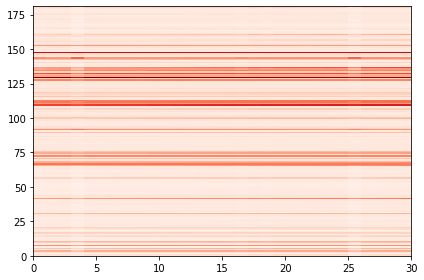

In [56]:
# plot raw rates
r_shape = rates.shape
rates_ex = rates[np.repeat(np.repeat(all_not_corr_channels, r_shape[1], 1), r_shape[0], 0)].reshape((r_shape[0], r_shape[1], -1))[timestep].T
plt.pcolormesh(rates_ex, cmap = cmap)
plt.tight_layout()
plt.savefig(f"viz_check_images/{model.name}_rates.png", facecolor='white', transparent=False)

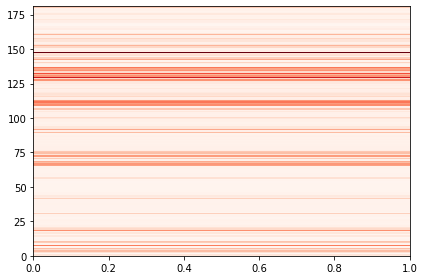

In [57]:
# plot mean
r_shape = rates.shape
all_means_no_corr_ch = np.concatenate(
    (
        heldin_rates_mean[np.expand_dims(heldin_not_corr_idxs, 0)], 
        heldout_rates_mean[np.expand_dims(heldout_not_corr_idxs, 0)]
    ), -1)
mean_ex = np.expand_dims(all_means_no_corr_ch, 0).T

plt.pcolormesh(mean_ex, cmap = cmap)
plt.tight_layout()
plt.savefig(f"viz_check_images/{model.name}_means.png", facecolor='white', transparent=False)

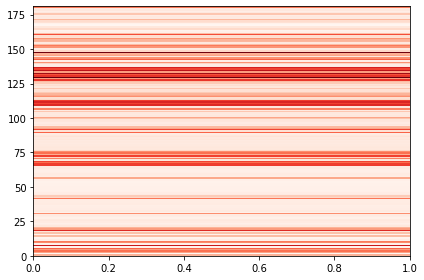

In [58]:
# plot stds
all_stds_no_corr_ch = np.concatenate(
    (
        heldin_rates_std[np.expand_dims(heldin_not_corr_idxs, 0)], 
        heldout_rates_std[np.expand_dims(heldout_not_corr_idxs, 0)]
    ), -1)
std_ex = np.expand_dims(all_stds_no_corr_ch,0).T

plt.pcolormesh(std_ex, cmap = cmap)
plt.tight_layout()
plt.savefig(f"viz_check_images/{model.name}_stds.png", facecolor='white', transparent=False)

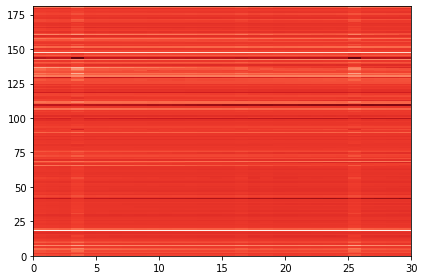

In [59]:
# plot mean subtracted rates
plt.pcolormesh(rates_mean_rem[timestep].T, cmap = cmap)
plt.tight_layout()
plt.savefig(f"viz_check_images/{model.name}_mean_sub_rates.png", facecolor='white', transparent=False)

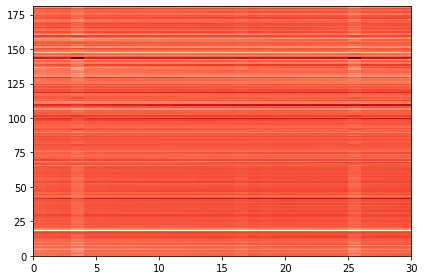

In [60]:
# plot std div'ed mean subtracted rates
std_mean_rem_rates_ex = all_rates_mean_rem_div_no_corr.reshape((ar_shape[0], ar_shape[1], -1))[timestep].T
plt.pcolormesh(std_mean_rem_rates_ex, cmap = cmap)
plt.tight_layout()
plt.savefig(f"viz_check_images/{model.name}_std_div_mean_sub_rates.png", facecolor='white', transparent=False)

In [61]:
def print_array(arr, x=None, y=None):
    for y_ in range(arr.shape[0] if y==None else y):
        line = ''
        for x_ in range(arr.shape[1] if x==None else x):
            line += f'{arr[y_,x_]:.3f}, '
        print(line)

In [62]:
# print raw rates
print_array(rates_ex, x=5, y=5)

0.081, 0.088, 0.094, 0.054, 0.094, 
0.027, 0.029, 0.030, 0.021, 0.031, 
0.096, 0.098, 0.099, 0.088, 0.099, 
0.207, 0.218, 0.222, 0.166, 0.224, 
0.065, 0.070, 0.071, 0.056, 0.074, 


In [63]:
# print means
print_array(mean_ex, y=5)

0.123, 
0.040, 
0.147, 
0.256, 
0.160, 


In [64]:
# print results after mean subtraction
print_array(rates_mean_rem[timestep].T, x=5, y=5)

-0.042, -0.035, -0.029, -0.069, -0.029, 
-0.013, -0.011, -0.009, -0.019, -0.009, 
-0.051, -0.049, -0.048, -0.059, -0.049, 
-0.049, -0.038, -0.034, -0.090, -0.032, 
-0.095, -0.090, -0.088, -0.104, -0.086, 


In [65]:
# print stds
print_array(std_ex, y=5)

0.376, 
0.205, 
0.406, 
0.504, 
0.421, 


In [66]:
# print results after std div
print_array(std_mean_rem_rates_ex, x=5, y=5)

-0.110, -0.093, -0.077, -0.183, -0.077, 
-0.061, -0.052, -0.046, -0.095, -0.046, 
-0.125, -0.121, -0.118, -0.146, -0.120, 
-0.098, -0.075, -0.068, -0.178, -0.064, 
-0.225, -0.213, -0.209, -0.246, -0.203, 


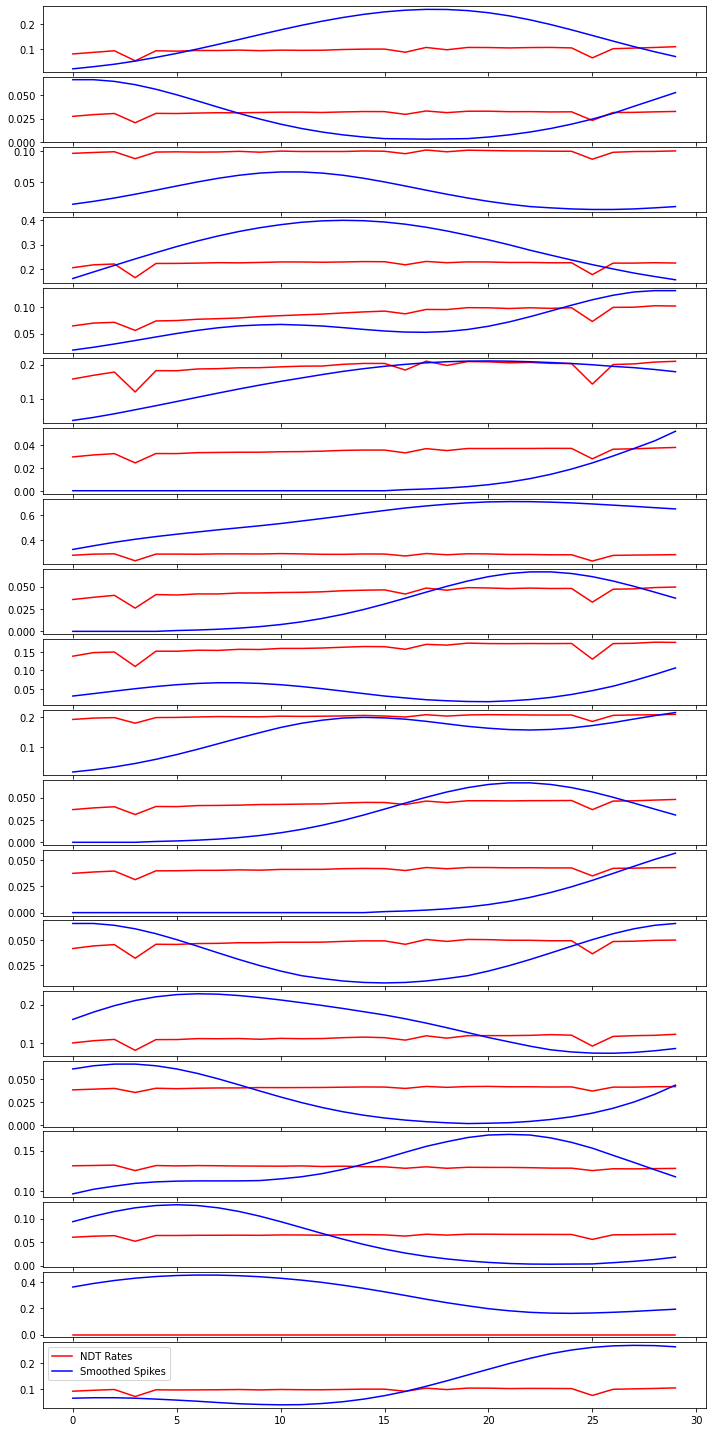

In [67]:
# plot ss vs rates in 30 bin output
timestep = 1

chans = 20
fig, ax = plt.subplots(nrows=chans, sharex=True, figsize=(10,chans*1))

for i in range(chans):
    ax[i].plot(rates_ex[i,:], 'r', label='NDT Rates')
    ax[i].plot(spikes_no_corr[timestep:timestep+30, i], 'b', label='Smoothed Spikes')
plt.tight_layout()
plt.legend()
plt.subplots_adjust(hspace=0.075)
plt.show()

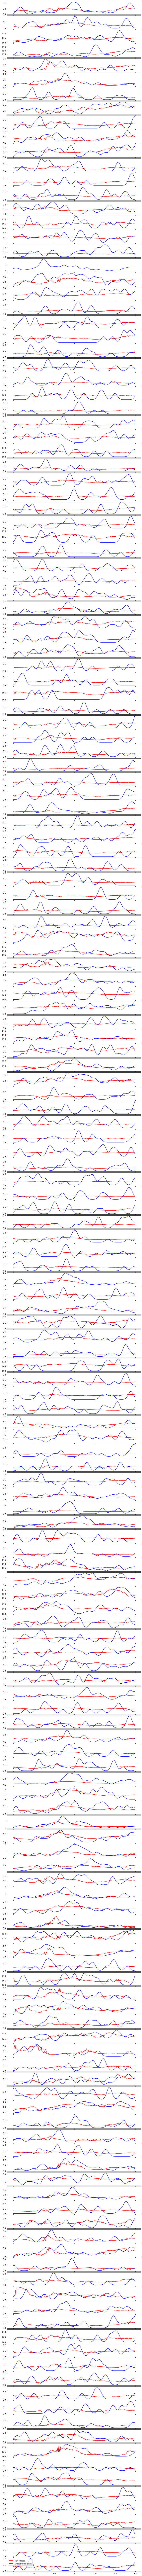

In [68]:
# plot ss vs rates in 30 bin output
timestep_r = [1, 300] 
chans = [0, 180]

n_chans = chans[1]-chans[0]
rates_lt = rates[np.repeat(np.repeat(all_not_corr_channels, r_shape[1], 1), r_shape[0], 0)].reshape((r_shape[0], r_shape[1], -1))
fig, ax = plt.subplots(nrows=n_chans, sharex=True, figsize=(10,n_chans*1))

for idx, i in enumerate(range(chans[0], chans[1])):
    ax[idx].plot(rates_lt[timestep_r[0]:timestep_r[1], -1, i], 'r', label='NDT Rates')
    ax[idx].plot(spikes_no_corr[timestep_r[0]:timestep_r[1], i], 'b', label='Smoothed Spikes')
plt.tight_layout()
plt.legend()
plt.subplots_adjust(hspace=0.075)
plt.show()